# SIRRS model

Model with multi-stage immune period, with immunity boosting. This model is desribed in terms of ODEs:


\begin{align*}
    \frac{dS}{dt} &= -\beta \frac{I(t)S(t)}{N} + \omega R_k(t)
    \\
    \frac{dI}{dt} &= \beta \frac{I(t)S(t)}{N} - \gamma I(t)
    \\
    \frac{dR_1}{dt} &= \gamma I(t) - \omega R_1(t) + \sum_{i=2}^{k} \tilde \beta \frac{I(t)R_i(t)}{N}
    \\
    \frac{dR_2}{dt} &= \omega R_1(t) - \omega R_2(t) - \tilde \beta \frac{I(t)R_2(t)}{N}
    \\
    & \; \vdots
    \\
    \frac{dR_k}{dt} &= \omega R_{k-1}(t) - \omega R_k(t) - \tilde \beta \frac{I(t)R_k(t)}{N}
\end{align*}


In [1]:
using DifferentialEquations

In [2]:
using StaticArrays

In [3]:
# ENV["MPLBACKEND"]="tkagg"

import PyPlot as plt
using PyCall: PyDict

rcParams = PyDict(plt.matplotlib["rcParams"])

rcParams["font.size"] = 14
rcParams["font.family"] = "serif"
rcParams["figure.figsize"] = (9, 5)
# rcParams["text.usetex"] = true
;

In [4]:
function SIR(state, params, t)
    β, γ = params
    S, I, R = state
    N = S + I + R
    dS = -β * S*I/N
    dI = β * S*I/N - γ*I
    dR = γ*I
    SA[dS, dI, dR]
end

SIR (generic function with 1 method)

In [5]:
initial_state = SA[9999.; 1.; 0.]
tspan = (0., 1.)
ts = LinRange(tspan[1], tspan[2], 1001)
prob = ODEProblem(SIR, initial_state, tspan, (50, 10); saveat=ts)
sol = solve(prob);

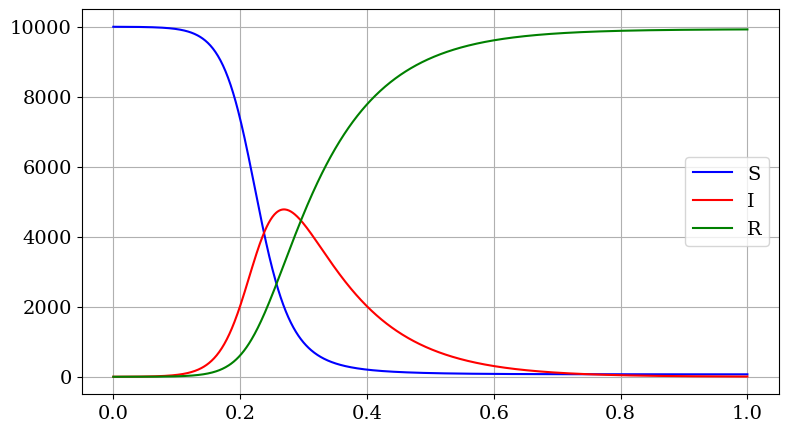

PyObject <matplotlib.legend.Legend object at 0x00000000DD864670>

In [6]:
plt.plot(sol.t, sol[1, 1:end], "b", label="S")
plt.plot(sol.t, sol[2, 1:end], "r", label="I")
plt.plot(sol.t, sol[3, 1:end], "g", label="R")
plt.grid()
plt.legend()
;

In [7]:
function SIRRS(state, params, t)
    β, γ, ω, β_ = params
    
    S = state[1]
    I = state[2]
    R = state[3:end]
    N = sum(state)
    
    dS = -β*I/N*S + ω * R[end]
    
    dI = β*I/N*S - γ*I
    
    dR = similar(R)
    dR[1] = γ*I - ω*R[1]
    for i in 2:length(R)
        dR[i] = ω*R[i-1] - ω*R[i] - β_*R[i]/N*I
        dR[1] += β_*R[i]/N*I
    end
    
    
    [dS, dI, dR...]
end;

SIRRS (generic function with 1 method)

Trying with parameters:

| **parameter** | $\beta$ | $\gamma$ | $\omega$ | $k$  | $\tilde \beta$|
|--------------:|---------|----------|----------|------|---------------|
| **value**     | $110$   | $36$     | $8$      | $16$ | $110$         |

In [8]:
initial_state = [9999., 1, zeros(16)...]
tspan = (0., 10.)
ts = LinRange(tspan[1], tspan[2], 1001)
prob = ODEProblem(SIRRS, initial_state, tspan, (110, 36, 8, 110); saveat=ts)
sol = solve(prob);

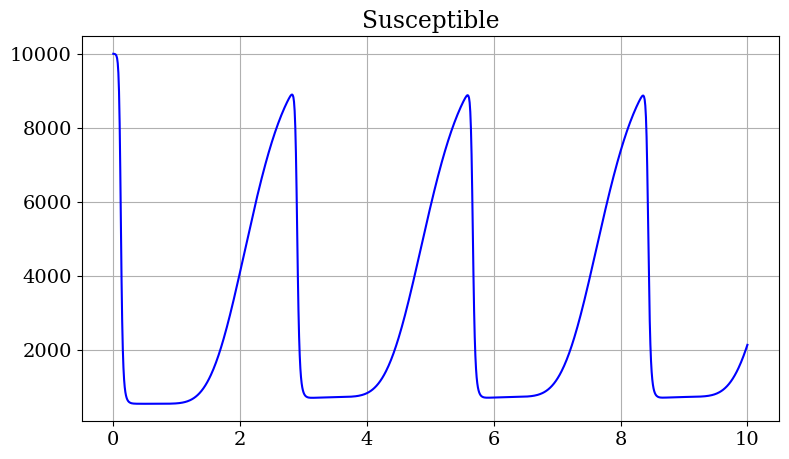

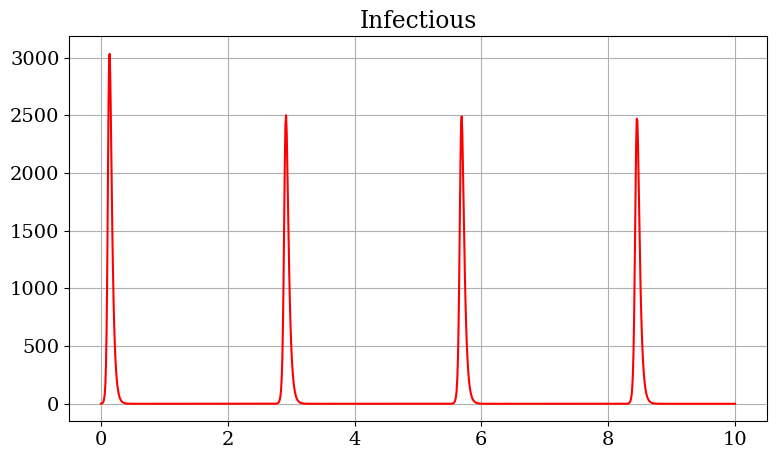

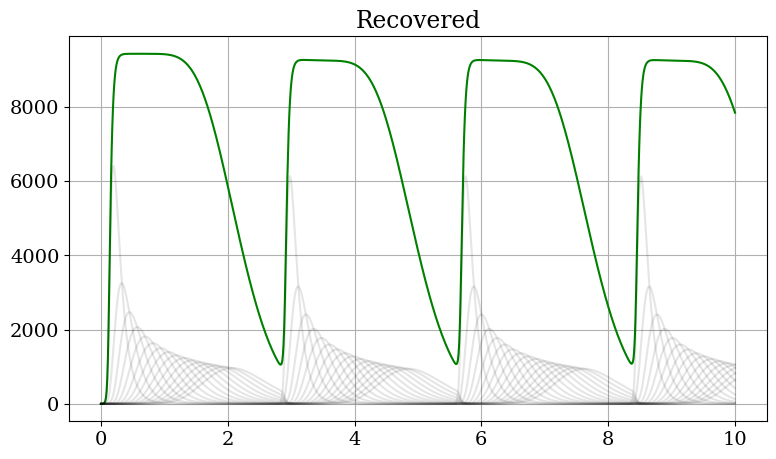

In [9]:
plt.figure()
plt.plot(sol.t, sol[1, 1:end], "b")
plt.title("Susceptible")
plt.grid()

plt.figure()
plt.plot(sol.t, sol[2, 1:end], "r")
plt.title("Infectious")
plt.grid()

plt.figure()
plt.plot(sol.t, sum(sol[3:end, 1:end], dims=1)[:], "g")
plt.plot(sol.t, transpose(sol[3:end, 1:end]), "k", alpha=0.1)
plt.title("Recovered")
plt.grid()
;

## Probability ditribution function of immune period

This is simply unit response to 

In [10]:
initial_state = [0, 0, 1., zeros(15)...]
tspan = (0., 4.)
ts = LinRange(tspan[1], tspan[2], 1001)
prob = ODEProblem(SIRRS, initial_state, tspan, (110, 36, 8, 110); saveat=ts)
sol = solve(prob);

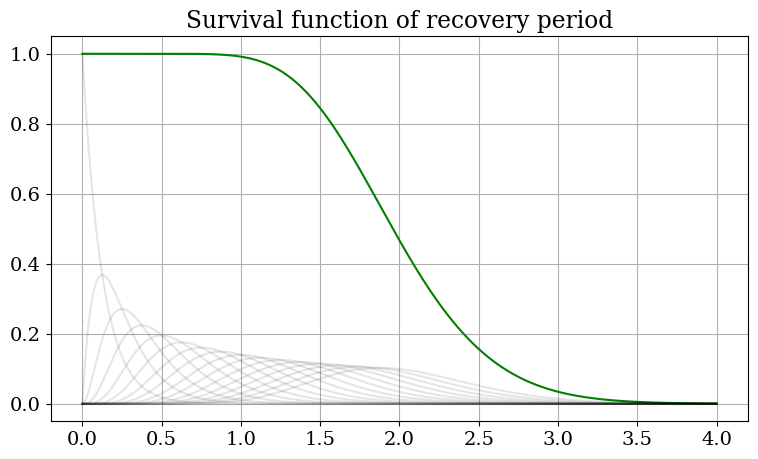

In [12]:
plt.figure()
plt.plot(sol.t, sum(sol[3:end, 1:end], dims=1)[:], "g")
plt.plot(sol.t, transpose(sol[3:end, 1:end]), "k", alpha=0.1)
plt.title("Survival function of recovery period")
plt.grid()
;

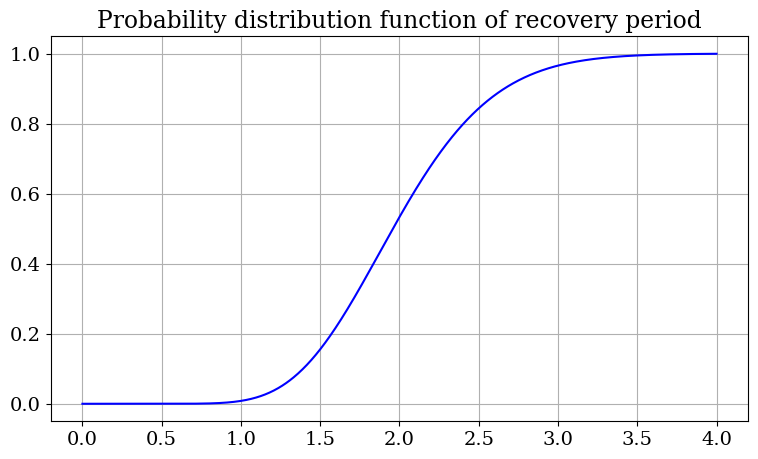

In [19]:
plt.figure()
plt.plot(sol.t, sol[1, 1:end], "b")
plt.title("Probability distribution function of recovery period")
plt.grid()
;